In [1]:
import pandas as pd
import os
import numpy as np
import requests
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import time
import json
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import openmeteo_requests
import requests_cache
from retry_requests import retry
import hsfs
from pathlib import Path
from dotenv import load_dotenv
import hopsworks
import sys

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from format_data import format_weather_data, format_price_data, merge_data
from get_electricity_prices import get_data
from get_weather_data import get_historical_weather, get_weather_forecast

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
load_dotenv()
hopsworks_api = os.getenv("HOPSWORKS_API_KEY")

os.environ["HOPSWORKS_API_KEY"] = hopsworks_api

project = hopsworks.login()
fs = project.get_feature_store() 
print(f"Connected to project: {project.name}")

2025-01-03 12:40:49,398 INFO: Initializing external client
2025-01-03 12:40:49,398 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-03 12:40:50,881 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164446
Connected to project: oskaralf


In [3]:
feature_view = fs.get_feature_view(
    name='electricity_price_fv',
    version=1,
)

In [4]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="electricity_xgboost_model",
    version=1,
)
saved_model_dir = retrieved_model.download()

In [5]:
saved_model_dir
retrieved_xgboost_model = xgb.XGBRegressor()
retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")
retrieved_xgboost_model

XGBRegressor(base_score='7.6731193E-1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)
weather_fg.show(10)
today_str = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
batch_data = weather_fg.filter(weather_fg['time_start'] >= today_str).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.49s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.51s) 


,time_start,temperature_2m,precipitation,snow_depth,pressure_msl,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,city
0,2025-01-03T22:00:00,-18.875999,0.0,0.14,991.599976,47.0,6.840000,3.706427,353.000000,60.945492,Luleå
1,2025-01-03T17:00:00,-15.326000,0.0,0.14,991.099976,95.0,4.320000,4.104631,308.000000,344.744812,Luleå
2,2025-01-03T18:00:00,-15.826000,0.0,0.14,990.900024,99.0,4.320000,1.609969,355.000000,333.435028,Luleå
3,2025-01-03T23:00:00,-19.425999,0.0,0.14,991.900024,62.0,6.120000,5.588703,342.000000,75.068535,Luleå
4,2025-01-03T13:00:00,-14.426000,0.0,0.14,990.500000,100.0,6.840000,16.263872,329.000000,332.300629,Luleå
...,...,...,...,...,...,...,...,...,...,...,...
150,2025-01-09T01:00:00,-6.150000,0.3,0.37,982.799988,100.0,18.532133,33.129780,352.184784,340.974304,Luleå
151,2025-01-09T11:00:00,-7.350000,0.5,0.37,979.599976,100.0,15.038350,39.599998,312.089081,323.130005,Luleå
152,2025-01-09T12:00:00,-7.450000,0.5,0.37,979.799988,100.0,14.400000,40.377815,306.869965,320.063690,Luleå
153,2025-01-09T19:00:00,-8.000000,0.1,0.36,982.099976,100.0,10.464798,41.475063,273.945099,306.173737,Luleå


In [7]:
batch_data['predicted_electricity_price'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'precipitation','snow_depth','pressure_msl','cloud_cover','wind_speed_10m','wind_speed_100m','wind_direction_10m','wind_direction_100m']])
batch_data

,time_start,temperature_2m,precipitation,snow_depth,pressure_msl,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,city,predicted_electricity_price
0,2025-01-03T22:00:00,-18.875999,0.0,0.14,991.599976,47.0,6.840000,3.706427,353.000000,60.945492,Luleå,0.604559
1,2025-01-03T17:00:00,-15.326000,0.0,0.14,991.099976,95.0,4.320000,4.104631,308.000000,344.744812,Luleå,0.915311
2,2025-01-03T18:00:00,-15.826000,0.0,0.14,990.900024,99.0,4.320000,1.609969,355.000000,333.435028,Luleå,1.322214
3,2025-01-03T23:00:00,-19.425999,0.0,0.14,991.900024,62.0,6.120000,5.588703,342.000000,75.068535,Luleå,1.067590
4,2025-01-03T13:00:00,-14.426000,0.0,0.14,990.500000,100.0,6.840000,16.263872,329.000000,332.300629,Luleå,0.811171
...,...,...,...,...,...,...,...,...,...,...,...,...
150,2025-01-09T01:00:00,-6.150000,0.3,0.37,982.799988,100.0,18.532133,33.129780,352.184784,340.974304,Luleå,0.246624
151,2025-01-09T11:00:00,-7.350000,0.5,0.37,979.599976,100.0,15.038350,39.599998,312.089081,323.130005,Luleå,0.143647
152,2025-01-09T12:00:00,-7.450000,0.5,0.37,979.799988,100.0,14.400000,40.377815,306.869965,320.063690,Luleå,0.095425
153,2025-01-09T19:00:00,-8.000000,0.1,0.36,982.099976,100.0,10.464798,41.475063,273.945099,306.173737,Luleå,0.265684


In [8]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   time_start                   155 non-null    object 
 1   temperature_2m               155 non-null    float32
 2   precipitation                155 non-null    float32
 3   snow_depth                   155 non-null    float32
 4   pressure_msl                 155 non-null    float32
 5   cloud_cover                  155 non-null    float32
 6   wind_speed_10m               155 non-null    float32
 7   wind_speed_100m              155 non-null    float32
 8   wind_direction_10m           155 non-null    float32
 9   wind_direction_100m          155 non-null    float32
 10  city                         155 non-null    object 
 11  predicted_electricity_price  155 non-null    float32
dtypes: float32(10), object(2)
memory usage: 8.6+ KB


2025-01-03 12:41:08,557 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



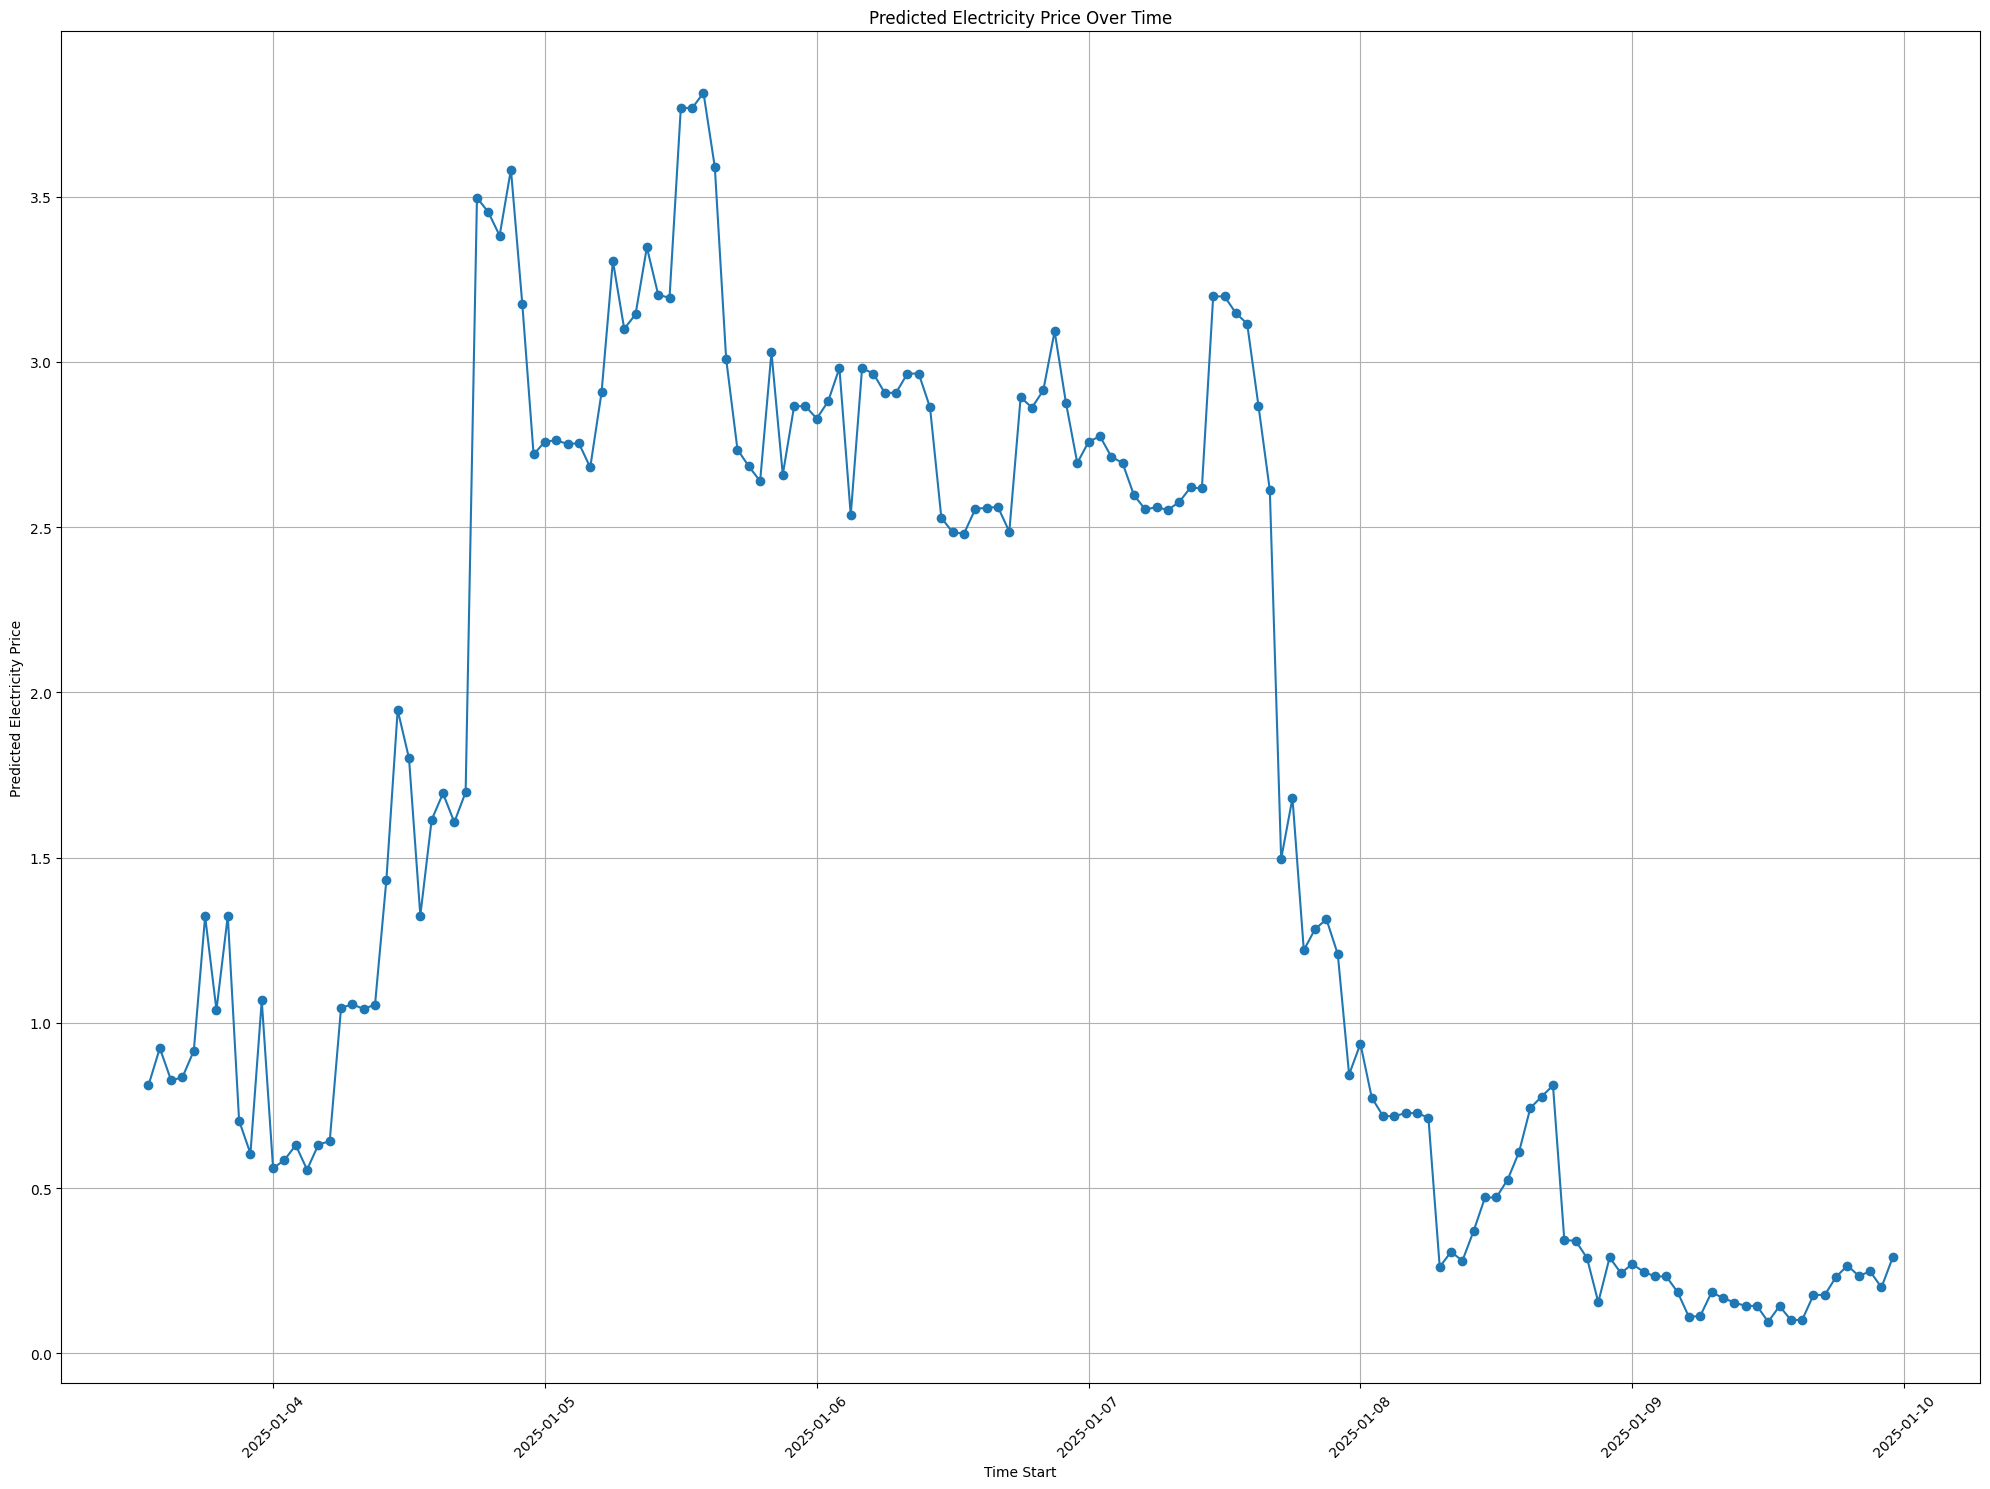

In [9]:

batch_data['time_start'] = pd.to_datetime(batch_data['time_start'], errors='coerce')
batch_data = batch_data.sort_values(by='time_start')

if batch_data['time_start'].isnull().any():
    raise ValueError("Some 'time_start' values could not be converted to datetime.")


plt.figure(figsize=(20, 15))
plt.plot(batch_data['time_start'], batch_data['predicted_electricity_price'], marker='o')
plt.xlabel('Time Start')
plt.ylabel('Predicted Electricity Price')
plt.title('Predicted Electricity Price Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()


output_dir = 'Images/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'predicted_electricity_price_over_time_SE4.png')
plt.savefig(output_path)

plt.show()